<a href="https://colab.research.google.com/github/galbraun/knesset_social_dynamics/blob/master/ERGM_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful links:
* Start with [introduction to ergm](https://cran.r-project.org/web/packages/ergm/vignettes/ergm.pdf)
* Example: [Lessons on exponential random graph modeling from Grey’s Anatomy hook-ups](http://badhessian.org/2012/09/lessons-on-exponential-random-graph-modeling-from-greys-anatomy-hook-ups/)


[introduction to ergm](https://cran.r-project.org/web/packages/ergm/vignettes/ergm.pdf)
1. begin with the simplest possible model, the Bernoulli (aka Erdős–Rényi) model, which contains only an edge term. Example in **pages 4-5**
2. Next, examine the influence of triangles on edges, which have positive effect. Moreover, we examine
the influence of a feature (wealth) on the edges, using nodecov('wealth'). We can see three * * * near to edges, with positive coefficient. Therefore there is a significant positive wealth effect on the probability of a tie **- pages 5-8**
3. Next example with big graphs irrelvant for us.
4. Example of simulate: pages 11-13


# Todo
1. add docs for each visualization - Together 
2. enlarge x-axis font & title (in all of the analsys sections) --- Gal
3. move titles in hebrew to global variables --- Gal
4. add data to github --- Gal
5. write code to use data from git --- Eli


In [1]:
# imports
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

%load_ext rpy2.ipython
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [2]:
# Todo: change to git clone and read data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Install R packages
%%capture
%%R
install.packages('network')
install.packages('ergm')
install.packages('sna')
install.packages('coda')
library(network)
library(ergm)
library(sna)
library(coda)

set.seed(1)

In [4]:
%%R
# return a network from features and adjacency matrices
build_network <- function(adj_mat_path, features_path) { 
    # read the adjacency matrix
    ga.mat <- as.matrix(read.table(adj_mat_path, sep=",", header=T, row.names=1, quote="\""))

    # read the network attributes
    ga.atts <- read.table(features_path, sep=",", header=T, quote="\"", stringsAsFactors=F, strip.white=T, as.is=T)

    # create a network object using the adjacency matrix and its corresponding attributes
    ga.net <- network(ga.mat, vertex.attr=ga.atts, vertex.attrnames=colnames(ga.atts), directed=T, hyper=F, loops=F, multiple=F, bipartite=F)

    return(ga.net)
}

In [44]:
# -o var to share 'var' between R and python

%%R -o huka_adj_path -o hutz_bitahon_adj_path -o knesset_adj_path -o ksafim_adj_path -o huka_feat_path -o hutz_bitahon_feat_path -o knesset_feat_path -o ksafim_feat_path -o mks_metadata_path
# adjacency matrices paths
huka_adj_path <- '/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/huka_adj.csv'
hutz_bitahon_adj_path <- '/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/hutz_bitahon_adj.csv'
knesset_adj_path <- '/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/knesset_adj.csv'
ksafim_adj_path <- '/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/ksafim_adj.csv'

# feature matrices paths
huka_feat_path <- '/content/drive/Shared drives/NLPSD/data/feature_matrixes/huka_feat.csv'
hutz_bitahon_feat_path <- '/content/drive/Shared drives/NLPSD/data/feature_matrixes/hutz_bitahon_feat.csv'
knesset_feat_path <- '/content/drive/Shared drives/NLPSD/data/feature_matrixes/knesset_feat.csv'
ksafim_feat_path <- '/content/drive/Shared drives/NLPSD/data/feature_matrixes/ksafim_feat.csv'

# Knesset members metadata path
mks_metadata_path <- '/content/drive/Shared drives/NLPSD/data/knesset_members_metadata.csv'

In [6]:
# build networks
%%R
huka_net = build_network(huka_adj_path, huka_feat_path)
hutz_bitahon_net = build_network(hutz_bitahon_adj_path, hutz_bitahon_feat_path)
knesset_net = build_network(knesset_adj_path, knesset_feat_path)
ksafim_net = build_network(ksafim_adj_path, ksafim_feat_path)

In [7]:
def draw_graph_from_adj(adj_path, ax=None, title=None):
  adj_matrix = pd.read_csv(adj_path, index_col=0)
  G = nx.convert_matrix.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
  pos=nx.kamada_kawai_layout(G)
  n_sizes = [50*d+10 for d in dict(G.degree).values()]
  labels = {node:node[::-1] for node in G.nodes()}
  nx.draw(G, node_size=n_sizes, ax=ax, pos=pos)
  nx.draw_networkx_labels(G,pos,labels=labels,font_size=10, ax=ax)

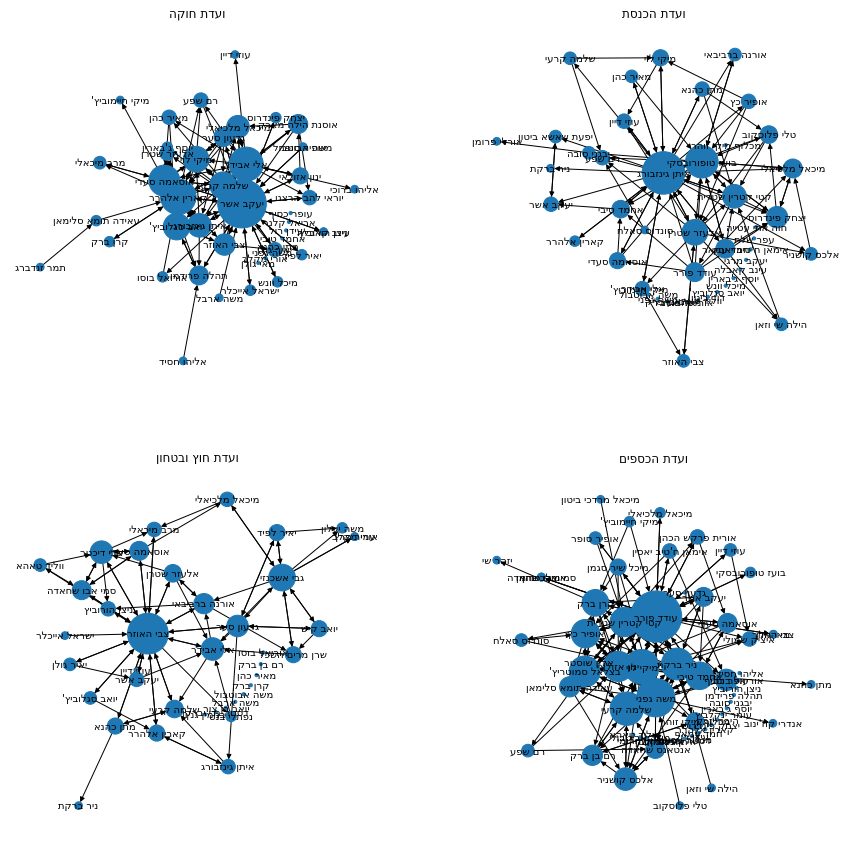

In [30]:
# plot Interruptions Networks
# Todo Gal: what the size influence here? I think just show the networks, in different layout (to be more understandable)
# Todo Gal: Set title
fig, axs = plt.subplots(2, 2, figsize=(15,15))

draw_graph_from_adj(huka_adj_path[0], ax=axs[0,0])
axs[0,0].set_title('ועדת חוקה'[::-1])

draw_graph_from_adj(hutz_bitahon_adj_path[0], ax=axs[1,0])
axs[1,0].set_title('ועדת חוץ ובטחון'[::-1])

draw_graph_from_adj(knesset_adj_path[0], ax=axs[0,1])
axs[0,1].set_title('ועדת הכנסת'[::-1])

draw_graph_from_adj(ksafim_adj_path[0], ax=axs[1,1])
axs[1,1].set_title('ועדת הכספים'[::-1])
fig.show()

### We begin with the simplest possible model, the Erdős–Rényi model, which contains only an edge term. Recall that a directed graph with $N$ vertices, has  maximum  $N\cdot (N-1)$ directed edges.

In [9]:
%%R
print(huka_net)

 Network attributes:
  vertices = 46 
  directed = TRUE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 130 
    missing edges= 0 
    non-missing edges= 130 

 Vertex attribute names: 
    age faction FirstName FullName gender in_col in_gov KM_id LastName pazam_knesset vertex.names wing 

No edge attributes


In [10]:
%%R
huka_net.01 <- ergm(huka_net ~ edges) # fit model
summary(huka_net.01)

R[write to console]: Starting maximum pseudolikelihood estimation (MPLE):

R[write to console]: Evaluating the predictor and response matrix.

R[write to console]: Maximizing the pseudolikelihood.

R[write to console]: Finished MPLE.

R[write to console]: Stopping at the initial estimate.

R[write to console]: Evaluating log-likelihood at the estimate. 
R[write to console]: 




Summary of model fit

Formula:   huka_net ~ edges

Iterations:  6 out of 20 

Monte Carlo MLE Results:
      Estimate Std. Error MCMC % z value Pr(>|z|)    
edges  -2.7029     0.0906      0  -29.84   <1e-04 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 2869.6  on 2070  degrees of freedom
 Residual Deviance:  971.3  on 2069  degrees of freedom
 
AIC: 973.3    BIC: 978.9    (Smaller is better.) 


#### Meaning that, the log-odds of any edge occurring is -2.7029. The corresponding probability is $\frac{e^{-2.7029}}{1+e^{-2.7029}} = 0.0628025$, which is what we expect, since there are $\frac{130}{46 \cdot 45}$ edges.

#### Now, we test whether edge probabilities are a function of pazam_knesset:

In [32]:
def draw_pazam_dist(adj_path, ax=None):
  df = pd.read_csv(adj_path)
  df['FullName'] = df['FullName'].apply(lambda x: x[::-1])
  df.sort_values('pazam_knesset', inplace=True)
  df.plot(kind='bar', rot=80, x='FullName', y='pazam_knesset', ax=ax)

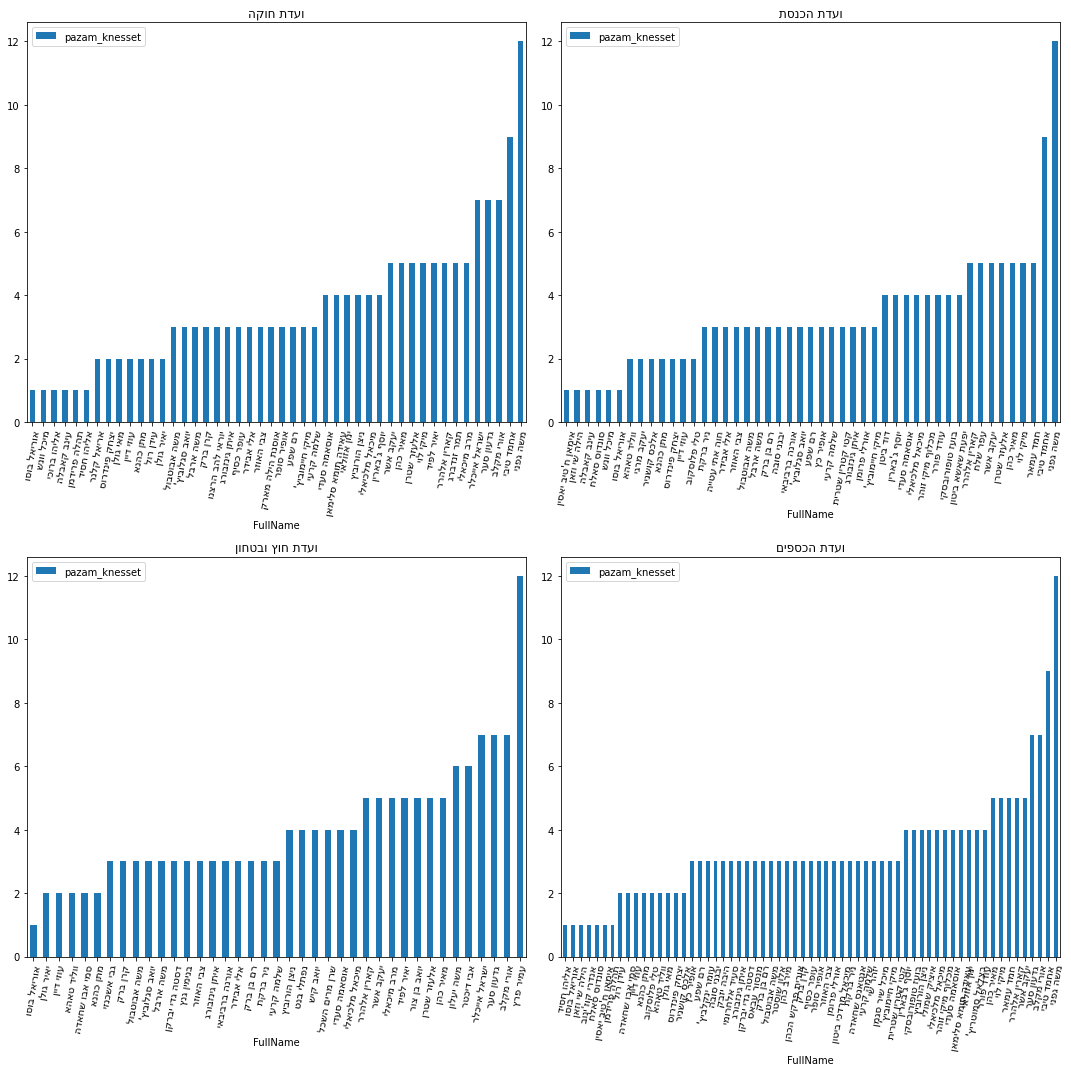

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))

draw_pazam_dist(huka_feat_path[0], ax=axs[0,0])
axs[0,0].set_title('ועדת חוקה'[::-1])

draw_pazam_dist(hutz_bitahon_feat_path[0], ax=axs[1,0])
axs[1,0].set_title('ועדת חוץ ובטחון'[::-1])

draw_pazam_dist(knesset_feat_path[0], ax=axs[0,1])
axs[0,1].set_title('ועדת הכנסת'[::-1])

draw_pazam_dist(ksafim_feat_path[0], ax=axs[1,1])
axs[1,1].set_title('ועדת הכספים'[::-1])

fig.tight_layout()

In [35]:
def draw_graph_from_adj_by_pazam(adj_path, feat_path, ax=None, title=None):
  adj_matrix = pd.read_csv(adj_path, index_col=0)
  feat_matrix = pd.read_csv(feat_path)
  G = nx.convert_matrix.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
  pos=nx.kamada_kawai_layout(G)
  n_sizes = [100*feat_matrix[feat_matrix['FullName'] == node]['pazam_knesset'].values[0] for node in G.nodes()]
  labels = {node:node[::-1] for node in G.nodes()}
  nx.draw(G, node_size=n_sizes, ax=ax, pos=pos)
  nx.draw_networkx_labels(G,pos,labels=labels,font_size=10, ax=ax)

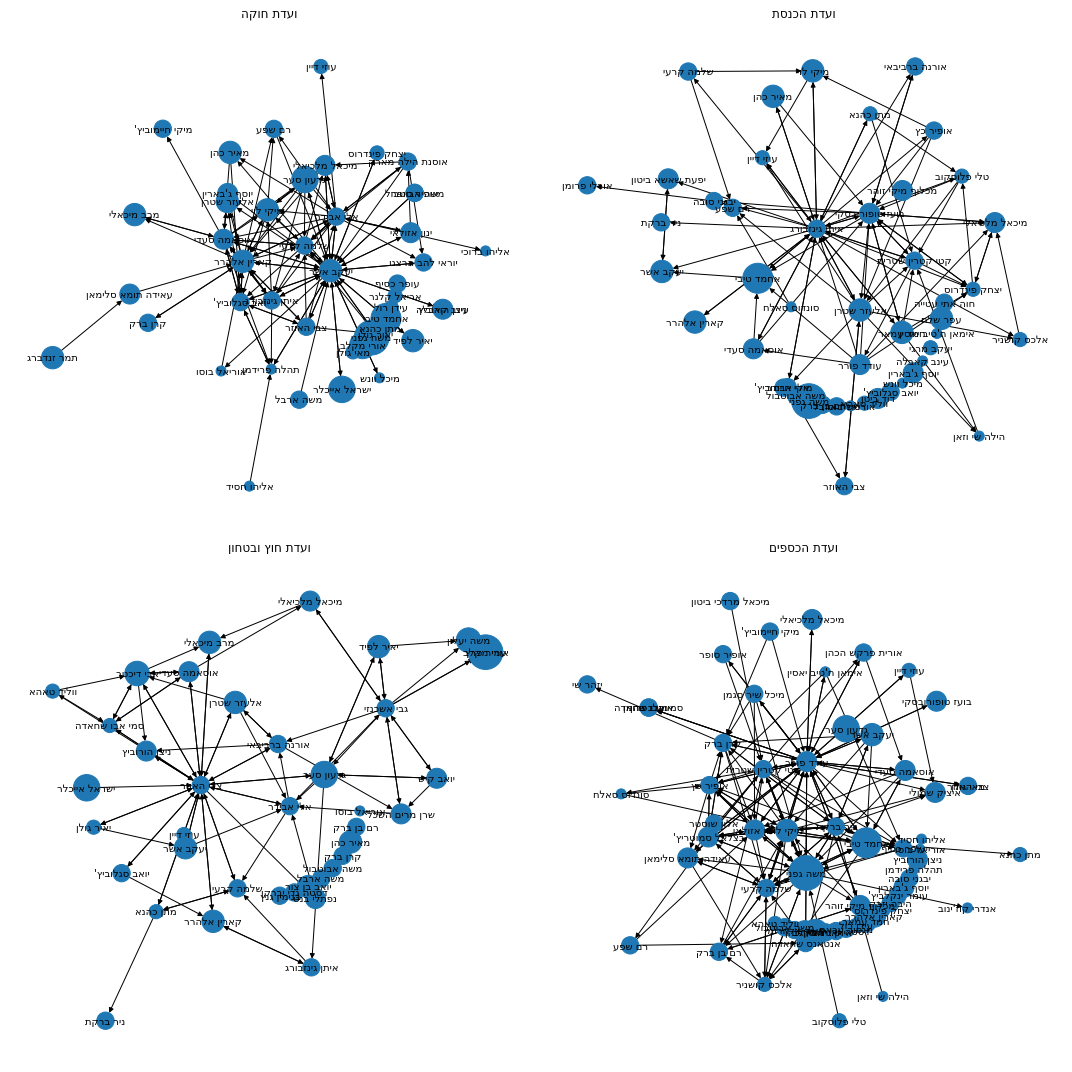

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))

draw_graph_from_adj_by_pazam(huka_adj_path[0], huka_feat_path[0], ax=axs[0,0])
axs[0,0].set_title('ועדת חוקה'[::-1])

draw_graph_from_adj_by_pazam(hutz_bitahon_adj_path[0], hutz_bitahon_feat_path[0], ax=axs[1,0])
axs[1,0].set_title('ועדת חוץ ובטחון'[::-1])

draw_graph_from_adj_by_pazam(knesset_adj_path[0], knesset_feat_path[0], ax=axs[0,1])
axs[0,1].set_title('ועדת הכנסת'[::-1])

draw_graph_from_adj_by_pazam(ksafim_adj_path[0], ksafim_feat_path[0], ax=axs[1,1])
axs[1,1].set_title('ועדת הכספים'[::-1])

fig.tight_layout()


In [15]:
%%capture
%%R
huka_net.pazam <- ergm(huka_net ~ edges + nodecov("pazam_knesset"))
hutz_bitahon_net.pazam <- ergm(hutz_bitahon_net ~ edges + nodecov("pazam_knesset"))
knesset_net.pazam <- ergm(knesset_net ~ edges + nodecov("pazam_knesset"))
ksafim_net.pazam <- ergm(ksafim_net ~ edges + nodecov("pazam_knesset"))

In [16]:
%%R
print("huka_net")
print(huka_net.pazam)
print(summary(huka_net.pazam))

print("hutz_bitahon_net")
print(hutz_bitahon_net.pazam)
print(summary(hutz_bitahon_net.pazam))

print("knesset_net")
print(knesset_net.pazam)
print(summary(knesset_net.pazam))

print("ksafim_net")
print(ksafim_net.pazam)
print(summary(ksafim_net.pazam))

[1] "huka_net"

MLE Coefficients:
                edges  nodecov.pazam_knesset  
             -3.13243                0.05696  

Summary of model fit

Formula:   huka_net ~ edges + nodecov("pazam_knesset")

Iterations:  5 out of 20 

Monte Carlo MLE Results:
                      Estimate Std. Error MCMC % z value Pr(>|z|)    
edges                 -3.13243    0.23475      0 -13.344   <1e-04 ***
nodecov.pazam_knesset  0.05696    0.02780      0   2.049   0.0405 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 2869.6  on 2070  degrees of freedom
 Residual Deviance:  967.3  on 2068  degrees of freedom
 
AIC: 971.3    BIC: 982.6    (Smaller is better.) 
[1] "hutz_bitahon_net"

MLE Coefficients:
                edges  nodecov.pazam_knesset  
             -2.35660               -0.05462  

Summary of model fit

Formula:   hutz_bitahon_net ~ edges + nodecov("pazam_knesset")

Iterations:  5 out of 20 

Monte Carlo MLE Results:
                      Es

# ==== Todo Conclusions 1 ====

לפי הויזואליזציות שיצרנו, ניתן לראות שבועידות כספים וחוקה, חברי כנסת עם דרגה גבוהה יותר, 
נקטעו או קטעו ע"י יותר חברי כנסת מאחרים. 
לדוגמה, יעקב אשר בועדת חוקה ומשה גפני בועדת כספים (אנו שמים לב שלרוב מדובר ביושבי ראש ל הועידה).
 את התוצאה הזו, אנו מוכיחים ע"י מודל ERGM:
שמראה שקיים יחס חיובי בין פזם בכנסת לבין תיווצר קשת בגרף (תהיה קטיעה) :
ניתן לראות שבועדת חוקה וכספים יחס חיובי בין הפזם בכנסת להופעת קשת באופן מובהק סטטיסטית כפי שניתן לראות בפלט של ERGM.
זאת בניגוד לגרפים האחרים של ועדת חוץ ובטחון וועדת הכנסת שם לא ניתן להגיד באופן מובהק סטטיסטית שיש קשר בין הפזם בכנסת להווצרות קשת כלומר לקטיעה.
ואת רואים בויזואליזציות של הגרפים וגם בפלט של מודל ERGM.
galb TODO  - להוסיף חרטוט על סיבת אמיתית למה זה מסתדר מבחינת הועדה בכנסת.



#### Next, we examine if two Knesset members within the same faction tend to   interrupt each other:

In [38]:
def draw_faction_dist(adj_path, ax=None, title=None):
  df = pd.read_csv(adj_path)
  df['faction'] = df['faction'].apply(lambda x: x[::-1])
  df['faction'].value_counts().plot(kind='bar', ax=ax, rot=60)
  ax.set_title(title, fontsize=20)
  for tick in ax.xaxis.get_major_ticks():
      tick.label.set_fontsize(14) 

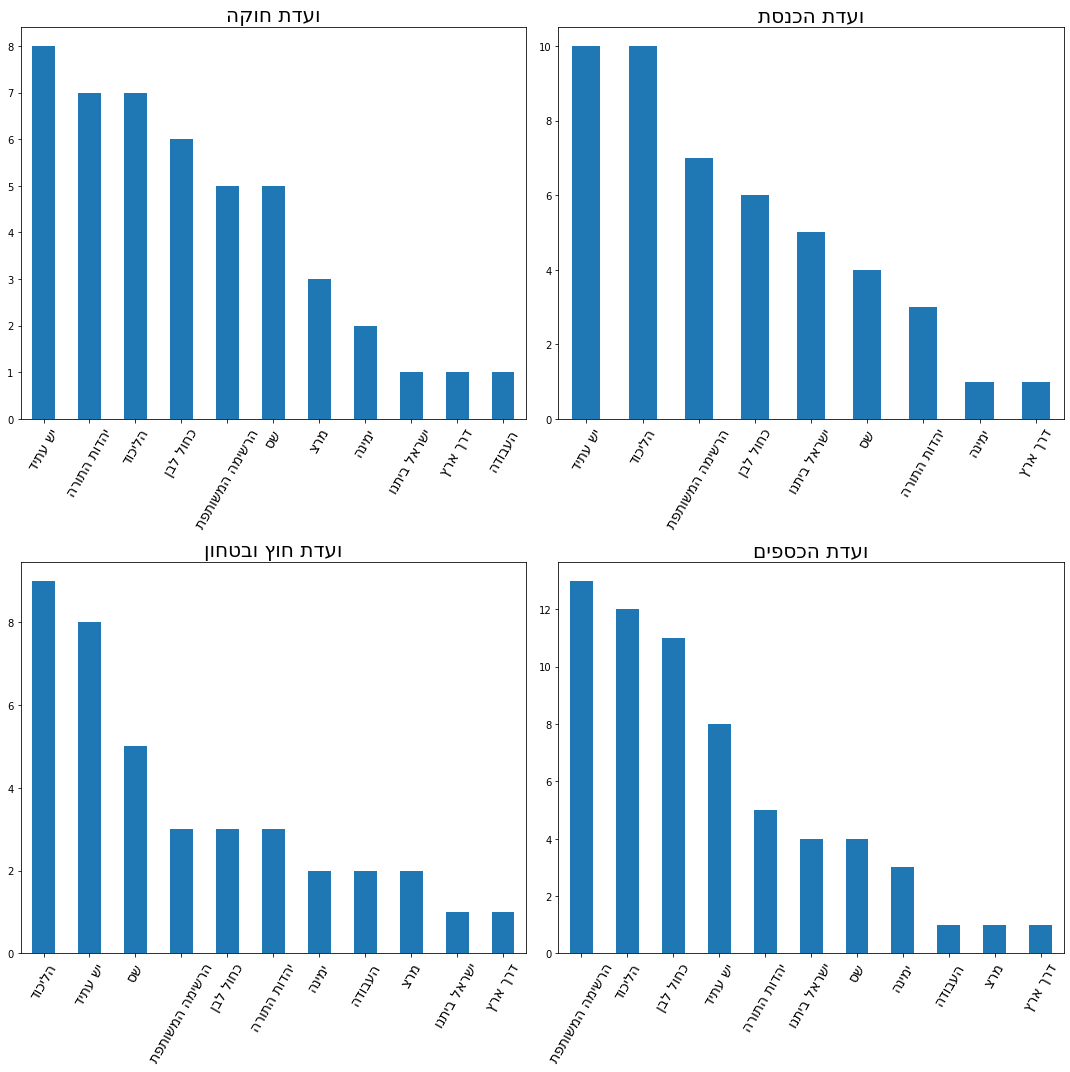

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))

draw_faction_dist(huka_feat_path[0], ax=axs[0,0], title='ועדת חוקה'[::-1])
draw_faction_dist(hutz_bitahon_feat_path[0], ax=axs[1,0], title='ועדת חוץ ובטחון'[::-1])
draw_faction_dist(knesset_feat_path[0], ax=axs[0,1], title='ועדת הכנסת'[::-1])
draw_faction_dist(ksafim_feat_path[0], ax=axs[1,1], title='ועדת הכספים'[::-1])

fig.tight_layout()

In [45]:
factions = pd.read_csv(mks_metadata_path[0])['faction'].unique()
fact_to_color = dict(zip(factions, cm.tab20.colors))

In [46]:
def draw_graph_from_adj_by_faction(adj_path, feat_path, ax=None, title=None):
  adj_matrix = pd.read_csv(adj_path, index_col=0)
  feat_matrix = pd.read_csv(feat_path)
  G = nx.convert_matrix.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
  pos=nx.kamada_kawai_layout(G)
  labels = {node:node[::-1] for node in G.nodes()}
  n_colors = [fact_to_color[feat_matrix[feat_matrix['FullName'] == node]['faction'].values[0]] for node in G.nodes()]
  nx.draw(G, node_color=n_colors , ax=ax, pos=pos)
  nx.draw_networkx_labels(G,pos,labels=labels,font_size=10, ax=ax)

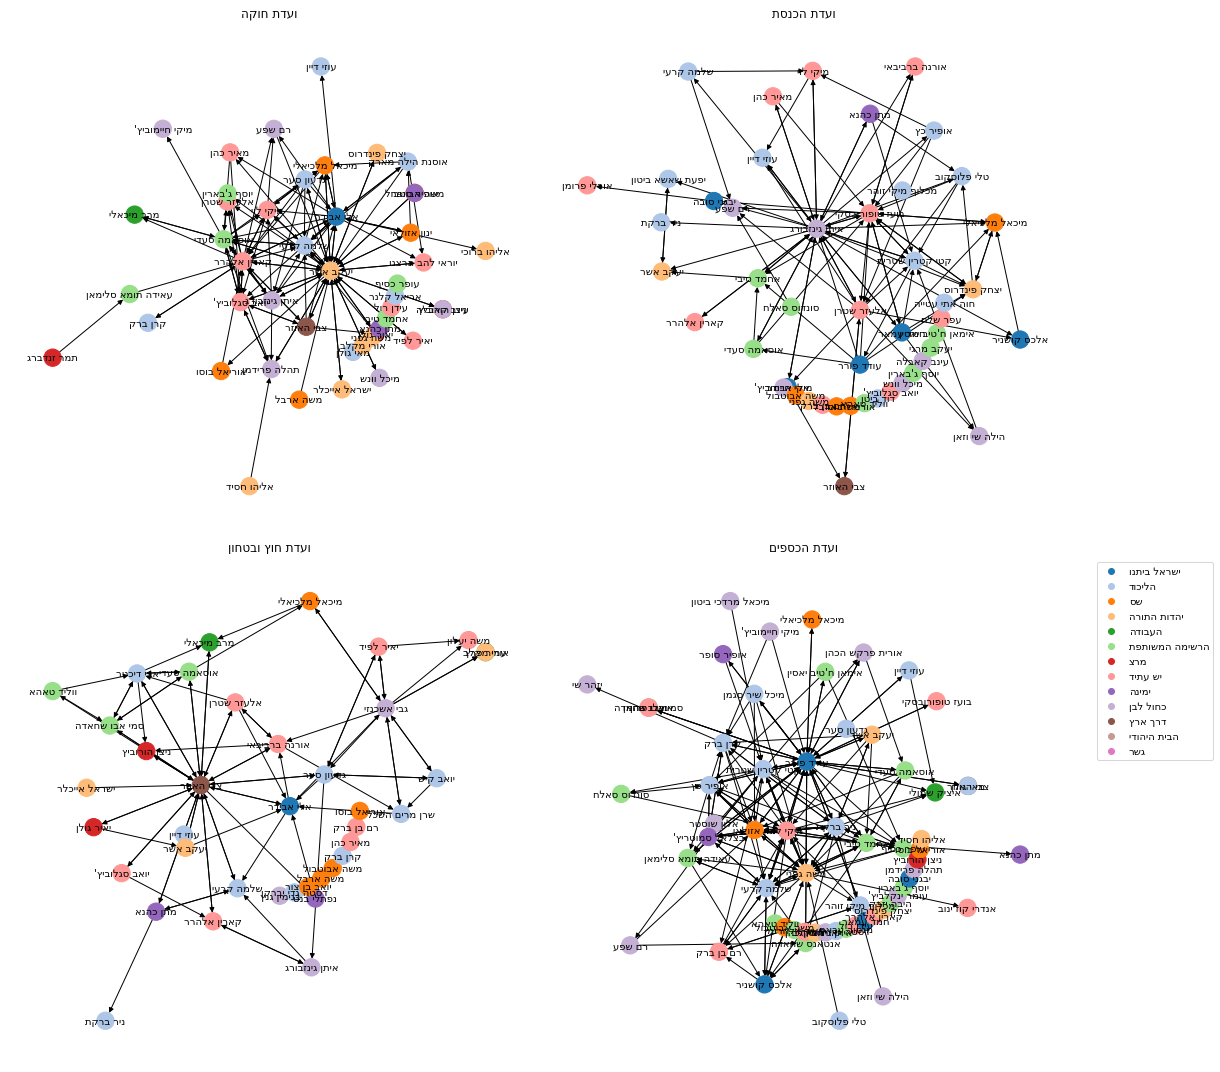

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))

draw_graph_from_adj_by_faction(huka_adj_path[0], huka_feat_path[0], ax=axs[0,0])
axs[0,0].set_title('ועדת חוקה'[::-1])

draw_graph_from_adj_by_faction(hutz_bitahon_adj_path[0], hutz_bitahon_feat_path[0], ax=axs[1,0])
axs[1,0].set_title('ועדת חוץ ובטחון'[::-1])

draw_graph_from_adj_by_faction(knesset_adj_path[0], knesset_feat_path[0], ax=axs[0,1])
axs[0,1].set_title('ועדת הכנסת'[::-1])

draw_graph_from_adj_by_faction(ksafim_adj_path[0], ksafim_feat_path[0], ax=axs[1,1])
axs[1,1].set_title('ועדת הכספים'[::-1])

fig.tight_layout()

fact_to_color_rev = {fact[::-1]:fact_to_color[fact] for fact in fact_to_color}
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in fact_to_color_rev.values()]
plt.legend(markers, fact_to_color_rev.keys(), numpoints=1, bbox_to_anchor=(1.05, 1.0), loc='upper left')

# TODO galb: find better layout so the names of the KM will be visible (in all of the analysis sections)
# TOOD galb: insert set_title to the function

In [22]:
%%capture
%%R
huka_net.faction <- ergm(huka_net ~ edges + nodematch("faction"))
hutz_bitahon_net.faction <- ergm(hutz_bitahon_net ~ edges + nodematch("faction"))
knesset_net.faction <- ergm(knesset_net ~ edges + nodematch("faction"))
ksafim_net.faction <- ergm(ksafim_net ~ edges + nodematch("faction"))

# TODO Elis check about nodefactor

In [23]:
%%R
print("huka_net")
print(huka_net.faction)
print(summary(huka_net.faction))

print("hutz_bitahon_net")
print(hutz_bitahon_net.faction)
print(summary(hutz_bitahon_net.faction))

print("knesset_net")
print(knesset_net.faction)
print(summary(knesset_net.faction))

print("ksafim_net")
print(ksafim_net.faction)
print(summary(ksafim_net.faction))


[1] "huka_net"

MLE Coefficients:
            edges  nodematch.faction  
          -2.7150             0.1098  

Summary of model fit

Formula:   huka_net ~ edges + nodematch("faction")

Iterations:  6 out of 20 

Monte Carlo MLE Results:
                  Estimate Std. Error MCMC % z value Pr(>|z|)    
edges             -2.71498    0.09629      0 -28.197   <1e-04 ***
nodematch.faction  0.10983    0.28437      0   0.386    0.699    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 2869.6  on 2070  degrees of freedom
 Residual Deviance:  971.1  on 2068  degrees of freedom
 
AIC: 975.1    BIC: 986.4    (Smaller is better.) 
[1] "hutz_bitahon_net"

MLE Coefficients:
            edges  nodematch.faction  
        -2.787283           0.002272  

Summary of model fit

Formula:   hutz_bitahon_net ~ edges + nodematch("faction")

Iterations:  6 out of 20 

Monte Carlo MLE Results:
                   Estimate Std. Error MCMC % z value Pr(>|z|)    
edges    

#### Let's look more in depth:

In [24]:
%%R
huka_net.faction2 <- ergm(huka_net ~ edges + nodematch('faction', diff=T))
summary(huka_net.faction2)

R[write to console]: Observed statistic(s) nodematch.faction.דרך ארץ, nodematch.faction.העבודה, nodematch.faction.הרשימה המשותפת, nodematch.faction.ימינה, nodematch.faction.ישראל ביתנו, nodematch.faction.מרצ, and nodematch.faction.שס are at their smallest attainable values. Their coefficients will be fixed at -Inf.

R[write to console]: Starting maximum pseudolikelihood estimation (MPLE):

R[write to console]: Evaluating the predictor and response matrix.

R[write to console]: Maximizing the pseudolikelihood.

R[write to console]: Finished MPLE.

R[write to console]: Stopping at the initial estimate.

R[write to console]: Evaluating log-likelihood at the estimate. 
R[write to console]: 




Summary of model fit

Formula:   huka_net ~ edges + nodematch("faction", diff = T)

Iterations:  6 out of 20 

Monte Carlo MLE Results:
                                 Estimate Std. Error MCMC % z value Pr(>|z|)
edges                            -2.71498    0.09629      0 -28.197   <1e-04
nodematch.faction.דרך ארץ            -Inf    0.00000      0    -Inf   <1e-04
nodematch.faction.הליכוד         -0.28075    0.73094      0  -0.384   0.7009
nodematch.faction.העבודה             -Inf    0.00000      0    -Inf   <1e-04
nodematch.faction.הרשימה המשותפת     -Inf    0.00000      0    -Inf   <1e-04
nodematch.faction.יהדות התורה     0.46369    0.53440      0   0.868   0.3856
nodematch.faction.ימינה              -Inf    0.00000      0    -Inf   <1e-04
nodematch.faction.יש עתיד         0.92322    0.39383      0   2.344   0.0191
nodematch.faction.ישראל ביתנו        -Inf    0.00000      0    -Inf   <1e-04
nodematch.faction.כחול לבן       -0.65231    1.02164      0  -0.638   0.5232
nodematch.factio

In [ ]:
# ==== Todo Conclusions 2 ====

# GAL TODO: add in_gov graphs

In [26]:
%%capture
%%R
huka_net.in_gov <- ergm(huka_net ~ edges + nodematch("in_gov"))
hutz_bitahon_net.in_gov <- ergm(hutz_bitahon_net ~ edges + nodematch("in_gov"))
knesset_net.in_gov <- ergm(knesset_net ~ edges + nodematch("in_gov"))
ksafim_net.in_gov <- ergm(ksafim_net ~ edges + nodematch("in_gov"))


In [27]:
%%R
print("huka_net")
print(huka_net.in_gov)
print(summary(huka_net.in_gov))

print("hutz_bitahon_net")
print(hutz_bitahon_net.in_gov)
print(summary(hutz_bitahon_net.in_gov))

print("knesset_net")
print(knesset_net.in_gov)
print(summary(knesset_net.in_gov))

print("ksafim_net")
print(ksafim_net.in_gov)
print(summary(ksafim_net.in_gov))


[1] "huka_net"

MLE Coefficients:
           edges  nodematch.in_gov  
          -18.21             15.55  

Summary of model fit

Formula:   huka_net ~ edges + nodematch("in_gov")

Iterations:  13 out of 20 

Monte Carlo MLE Results:
                 Estimate Std. Error MCMC % z value Pr(>|z|)
edges              -18.21     574.62      0  -0.032    0.975
nodematch.in_gov    15.55     574.62      0   0.027    0.978

     Null Deviance: 2869.6  on 2070  degrees of freedom
 Residual Deviance:  959.3  on 2068  degrees of freedom
 
AIC: 963.3    BIC: 974.6    (Smaller is better.) 
[1] "hutz_bitahon_net"

MLE Coefficients:
           edges  nodematch.in_gov  
         -3.5104            0.9329  

Summary of model fit

Formula:   hutz_bitahon_net ~ edges + nodematch("in_gov")

Iterations:  6 out of 20 

Monte Carlo MLE Results:
                 Estimate Std. Error MCMC % z value Pr(>|z|)    
edges             -3.5104     0.2815      0 -12.472  < 1e-04 ***
nodematch.in_gov   0.9329     0.3065 

# GAL TODO: add in_col graphs

In [29]:
%%capture
%%R
huka_net.in_col <- ergm(huka_net ~ edges + nodematch("in_col"))
hutz_bitahon_net.in_col <- ergm(hutz_bitahon_net ~ edges + nodematch("in_col"))
knesset_net.in_col <- ergm(knesset_net ~ edges + nodematch("in_col"))
ksafim_net.in_col <- ergm(ksafim_net ~ edges + nodematch("in_col"))

In [30]:
%%R
print("huka_net")
print(huka_net.in_col)
print(summary(huka_net.in_col))

print("hutz_bitahon_net")
print(hutz_bitahon_net.in_col)
print(summary(hutz_bitahon_net.in_col))

print("knesset_net")
print(knesset_net.in_col)
print(summary(knesset_net.in_col))

print("ksafim_net")
print(ksafim_net.in_col)
print(summary(ksafim_net.in_col))

[1] "huka_net"

MLE Coefficients:
           edges  nodematch.in_col  
           -2.63             -0.15  

Summary of model fit

Formula:   huka_net ~ edges + nodematch("in_col")

Iterations:  6 out of 20 

Monte Carlo MLE Results:
                 Estimate Std. Error MCMC % z value Pr(>|z|)    
edges             -2.6297     0.1247      0 -21.097   <1e-04 ***
nodematch.in_col  -0.1500     0.1815      0  -0.827    0.408    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 2869.6  on 2070  degrees of freedom
 Residual Deviance:  970.6  on 2068  degrees of freedom
 
AIC: 974.6    BIC: 985.9    (Smaller is better.) 
[1] "hutz_bitahon_net"

MLE Coefficients:
           edges  nodematch.in_col  
         -2.6626           -0.2623  

Summary of model fit

Formula:   hutz_bitahon_net ~ edges + nodematch("in_col")

Iterations:  6 out of 20 

Monte Carlo MLE Results:
                 Estimate Std. Error MCMC % z value Pr(>|z|)    
edges             -2.662

# GAL TODO: add gender graphs

In [31]:
%%capture
%%R
huka_net.gender <- ergm(huka_net ~ edges + nodematch("gender"))
hutz_bitahon_net.gender <- ergm(hutz_bitahon_net ~ edges + nodematch("gender"))
knesset_net.gender <- ergm(knesset_net ~ edges + nodematch("gender"))
ksafim_net.gender <- ergm(ksafim_net ~ edges + nodematch("gender"))

In [32]:
%%R
print("huka_net")
print(huka_net.gender)
print(summary(huka_net.gender))

print("hutz_bitahon_net")
print(hutz_bitahon_net.gender)
print(summary(hutz_bitahon_net.gender))

print("knesset_net")
print(knesset_net.gender)
print(summary(knesset_net.gender))

print("ksafim_net")
print(ksafim_net.gender)
print(summary(ksafim_net.gender))

[1] "huka_net"

MLE Coefficients:
           edges  nodematch.gender  
         -2.8781            0.2675  

Summary of model fit

Formula:   huka_net ~ edges + nodematch("gender")

Iterations:  6 out of 20 

Monte Carlo MLE Results:
                 Estimate Std. Error MCMC % z value Pr(>|z|)    
edges             -2.8781     0.1605      0 -17.932   <1e-04 ***
nodematch.gender   0.2675     0.1945      0   1.376    0.169    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 2869.6  on 2070  degrees of freedom
 Residual Deviance:  969.3  on 2068  degrees of freedom
 
AIC: 973.3    BIC: 984.6    (Smaller is better.) 
[1] "hutz_bitahon_net"

MLE Coefficients:
           edges  nodematch.gender  
        -2.77259          -0.01876  

Summary of model fit

Formula:   hutz_bitahon_net ~ edges + nodematch("gender")

Iterations:  6 out of 20 

Monte Carlo MLE Results:
                 Estimate Std. Error MCMC % z value Pr(>|z|)    
edges            -2.7725

# GAL TODO: add wing graphs

In [34]:
%%capture
%%R
huka_net.wing <- ergm(huka_net ~ edges + nodematch("wing"))
hutz_bitahon_net.wing <- ergm(hutz_bitahon_net ~ edges + nodematch("wing"))
knesset_net.wing <- ergm(knesset_net ~ edges + nodematch("wing"))
ksafim_net.wing <- ergm(ksafim_net ~ edges + nodematch("wing"))

In [35]:
%%R
print("huka_net")
print(huka_net.wing)
print(summary(huka_net.wing))

print("hutz_bitahon_net")
print(hutz_bitahon_net.wing)
print(summary(hutz_bitahon_net.wing))

print("knesset_net")
print(knesset_net.wing)
print(summary(knesset_net.wing))

print("ksafim_net")
print(ksafim_net.wing)
print(summary(ksafim_net.wing))


[1] "huka_net"

MLE Coefficients:
         edges  nodematch.wing  
       -2.8446          0.3511  

Summary of model fit

Formula:   huka_net ~ edges + nodematch("wing")

Iterations:  6 out of 20 

Monte Carlo MLE Results:
               Estimate Std. Error MCMC % z value Pr(>|z|)    
edges           -2.8446     0.1212      0 -23.464   <1e-04 ***
nodematch.wing   0.3511     0.1827      0   1.922   0.0546 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 2869.6  on 2070  degrees of freedom
 Residual Deviance:  967.6  on 2068  degrees of freedom
 
AIC: 971.6    BIC: 982.9    (Smaller is better.) 
[1] "hutz_bitahon_net"

MLE Coefficients:
         edges  nodematch.wing  
       -2.8881          0.2452  

Summary of model fit

Formula:   hutz_bitahon_net ~ edges + nodematch("wing")

Iterations:  6 out of 20 

Monte Carlo MLE Results:
               Estimate Std. Error MCMC % z value Pr(>|z|)    
edges           -2.8881     0.1483      0 -19.474   

# GAL TODO: add age graphs

In [ ]:
def draw_graph_from_adj_by_age(adj_path, feat_path, ax=None, title=None):
  adj_matrix = pd.read_csv(adj_path, index_col=0)
  feat_matrix = pd.read_csv(feat_path)
  G = nx.convert_matrix.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
  pos=nx.kamada_kawai_layout(G)
  n_sizes = [10*feat_matrix[feat_matrix['FullName'] == node]['age'].values[0] for node in G.nodes()]
  labels = {node:node[::-1] for node in G.nodes()}
  nx.draw(G, node_size=n_sizes, ax=ax, pos=pos)
  nx.draw_networkx_labels(G,pos,labels=labels,font_size=10, ax=ax)

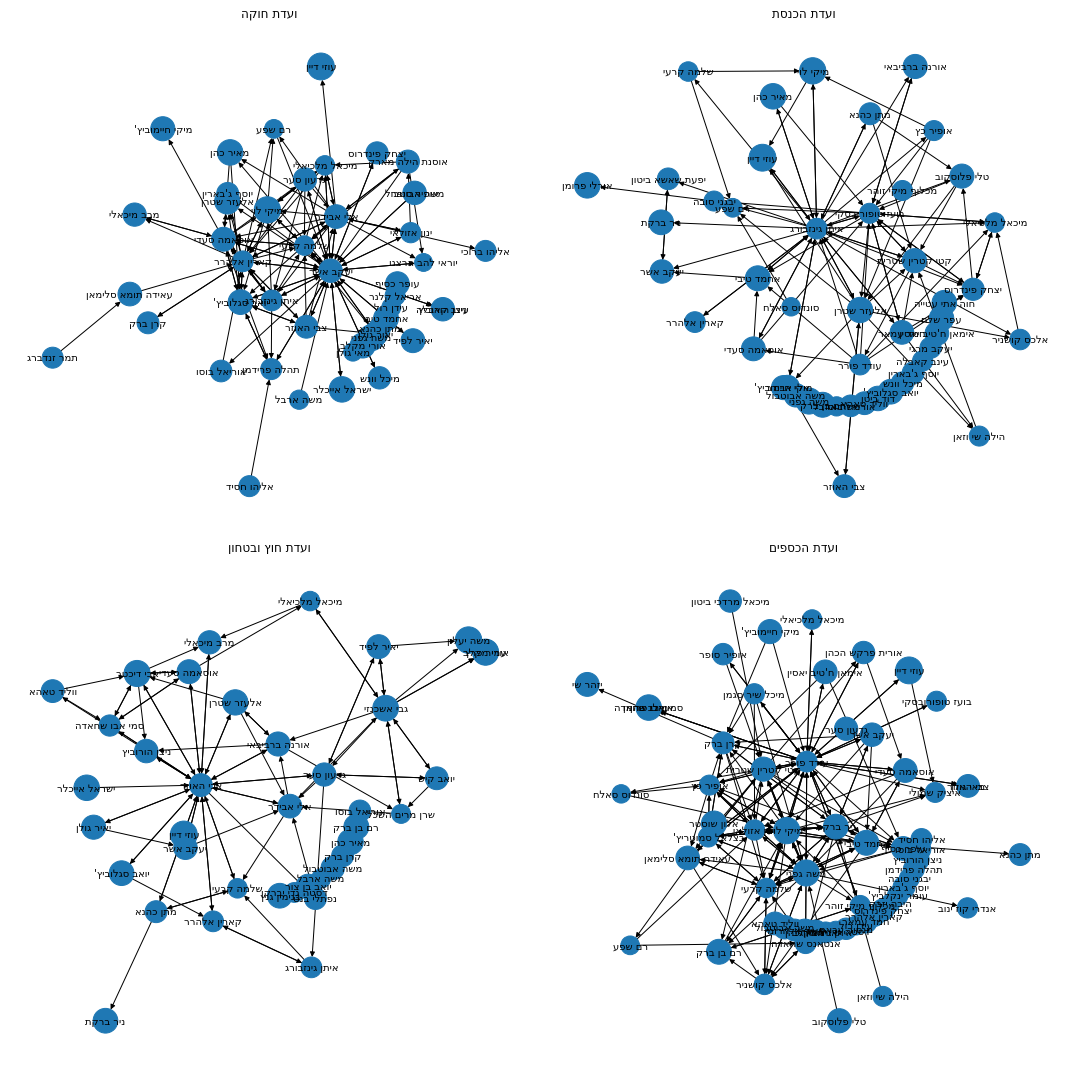

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))

draw_graph_from_adj_by_age('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/huka_adj.csv', '/content/drive/Shared drives/NLPSD/data/feature_matrixes/huka_feat.csv', ax=axs[0,0])
axs[0,0].set_title('ועדת חוקה'[::-1])

draw_graph_from_adj_by_age('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/hutz_bitahon_adj.csv', '/content/drive/Shared drives/NLPSD/data/feature_matrixes/hutz_bitahon_feat.csv', ax=axs[1,0])
axs[1,0].set_title('ועדת חוץ ובטחון'[::-1])

draw_graph_from_adj_by_age('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/knesset_adj.csv', '/content/drive/Shared drives/NLPSD/data/feature_matrixes/knesset_feat.csv', ax=axs[0,1])
axs[0,1].set_title('ועדת הכנסת'[::-1])

draw_graph_from_adj_by_age('/content/drive/Shared drives/NLPSD/data/adjacency_matrixes/ksafim_adj.csv', '/content/drive/Shared drives/NLPSD/data/feature_matrixes/ksafim_feat.csv', ax=axs[1,1])
axs[1,1].set_title('ועדת הכספים'[::-1])

fig.tight_layout()


In [37]:
%%capture
%%R
huka_net.age <- ergm(huka_net ~ edges + nodecov("age"))
hutz_bitahon_net.age <- ergm(hutz_bitahon_net ~ edges + nodecov("age"))
knesset_net.age <- ergm(knesset_net ~ edges + nodecov("age"))
ksafim_net.age <- ergm(ksafim_net ~ edges + nodecov("age"))

In [38]:
%%R
print("huka_net")
print(huka_net.age)
print(summary(huka_net.age))

print("hutz_bitahon_net")
print(hutz_bitahon_net.age)
print(summary(hutz_bitahon_net.age))

print("knesset_net")
print(knesset_net.age)
print(summary(knesset_net.age))

print("ksafim_net")
print(ksafim_net.age)
print(summary(ksafim_net.age))

[1] "huka_net"

MLE Coefficients:
      edges  nodecov.age  
  -3.601478     0.008785  

Summary of model fit

Formula:   huka_net ~ edges + nodecov("age")

Iterations:  4 out of 20 

Monte Carlo MLE Results:
             Estimate Std. Error MCMC % z value Pr(>|z|)    
edges       -3.601478   0.667637      0  -5.394   <1e-04 ***
nodecov.age  0.008785   0.006419      0   1.369    0.171    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 2869.6  on 2070  degrees of freedom
 Residual Deviance:  969.4  on 2068  degrees of freedom
 
AIC: 973.4    BIC: 984.7    (Smaller is better.) 
[1] "hutz_bitahon_net"

MLE Coefficients:
      edges  nodecov.age  
  -2.170707    -0.005658  

Summary of model fit

Formula:   hutz_bitahon_net ~ edges + nodecov("age")

Iterations:  4 out of 20 

Monte Carlo MLE Results:
             Estimate Std. Error MCMC % z value Pr(>|z|)  
edges       -2.170707   0.889046      0  -2.442   0.0146 *
nodecov.age -0.005658   0.008133 

In [39]:
# %%R
# data(florentine)
# flomodel.03 <- ergm(flomarriage~edges+nodecov('wealth'))

# flomodel.03.sim <- simulate(flomodel.03,nsim=10)

# %%R
# summary(flomodel.03.sim)

# %%R
# plot(flomodel.03.sim[[3]], label= flomodel.03.sim[[3]] %v% "vertex.names")